# Assignment 1 for FIT5212, Semester 1, 2020

**Student Name:**  Haoheng Zhu

**Student ID:**    30376467

**Tutor Name:**    Mohammad Haqquni

## Part 1:  Text Classification

General comments and any shared processing here.

In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
rawData = pd.read_csv('axcs_train.csv', sep=',')

In [3]:
rawData.sample(10)

ID                           URL        Date  \
33301     no-13016644       arxiv.org/abs/1301.6644  2013-01-28   
26061     no-12036758       arxiv.org/abs/1203.6758  2012-03-30   
24854     no-12022427       arxiv.org/abs/1202.2427  2012-02-11   
47909     no-13124113       arxiv.org/abs/1312.4113  2014-05-29   
10684     no-09053769       arxiv.org/abs/0905.3769  2009-05-22   
664    cmp-lg-9607020  arxiv.org/abs/cmp-lg/9607020  1996-07-15   
40274     no-13096347       arxiv.org/abs/1309.6347  2013-09-24   
7279      no-07120105       arxiv.org/abs/0712.0105  2007-12-03   
22600     no-11102205       arxiv.org/abs/1110.2205  2011-10-10   
19572     no-11045387       arxiv.org/abs/1104.5387  2011-04-28   

                                                   Title  InfoTheory  CompVis  \
33301  Simplifying the Configuration of 802.11 Wirele...           0        0   
26061  Spectral Differentiation Operators and Hydrody...           0        0   
24854  Autonomic html interface generator for web app...           0        0   
47909  Lessons Learned from Development of a Software...           0        0   
10684                      Multiset Ordering Constraints           0        0   
664            A Divide-and-Conquer Strategy for Parsing           0        0   
40274  Tracking Sentiment in Mail: How Genders Differ...           0        0   
7279   On estimating the memory for finitarily Markov...           1        0   
22600  Answer Sets for Logic Programs with Arbitrary ...           0        0   
19572  Model based system engineering approach of a l...           0        0   

       Math                                           Abstract  
33301     0   Simplifying the Configuration of 802.11 Wirel...  
26061     1   Spectral Differentiation Operators and Hydrod...  
24854     0   Autonomic html interface generator for web ap...  
47909     0   Lessons Learned from Development of a Softwar...  
10684     0   Multiset Ordering Constraints We identify a n...  
664       0   A Divide-and-Conquer Strategy for Parsing In ...  
40274     0   Tracking Sentiment in Mail: How Genders Diffe...  
7279      1   On estimating the memory for finitarily Marko...  
22600     0   Answer Sets for Logic Programs with Arbitrary...  
19572     0   Model based system engineering approach of a ...

#### Check data structure

In [4]:
rawData.dtypes

ID            object
URL           object
Date          object
Title         object
InfoTheory     int64
CompVis        int64
Math           int64
Abstract      object
dtype: object

#### Check NA or missing values for each column

In [7]:
rawData.isna().sum()

ID            0
URL           0
Date          0
Title         0
InfoTheory    0
CompVis       0
Math          0
Abstract      0
dtype: int64

#### Check datatype, NA or missing values for test data

In [9]:
testData = pd.read_csv('axcs_test.csv', sep=',')
testData.isna().sum()


ID            0
URL           0
Date          0
Title         0
InfoTheory    1
CompVis       1
Math          1
Abstract      1
dtype: int64

#### Show the NA row

In [10]:
testData[testData.isna().any(axis=1)]

ID                       URL        Date  \
19619  no-160308961  arxiv.org/abs/1603.08961  2016-03-29   

                                                   Title  InfoTheory  CompVis  \
19619  Betting and Belief: Prediction Markets and Att...         NaN      NaN   

       Math Abstract  
19619   NaN      NaN

#### drop the NA row

In [11]:
testData = testData.drop(testData.index[19619])

In [12]:
testData.dtypes

ID             object
URL            object
Date           object
Title          object
InfoTheory    float64
CompVis       float64
Math          float64
Abstract       object
dtype: object

#### Change datatype for test dataset

In [13]:
testData = testData.astype({'InfoTheory': 'int'})
testData = testData.astype({'CompVis': 'int'})
testData = testData.astype({'Math': 'int'})

In [14]:
testData.dtypes

ID            object
URL           object
Date          object
Title         object
InfoTheory     int32
CompVis        int32
Math           int32
Abstract      object
dtype: object

In [15]:
testData.to_csv('testData.csv', index=False)

In [16]:
train_data = pd.read_csv('axcs_train.csv', sep=',')

In [17]:
from sklearn.model_selection import train_test_split

trainData, valData = train_test_split(train_data, test_size=0.25, random_state=1)
valData.to_csv('axcs_val.csv', index=False)
trainData.to_csv('axcsTrain.csv', index=False)

### Part 1: Neural Network Method


**recurrent neural network** (RNN) is commonly used in analysing sequences. An RNN takes in sequence of words, $X=\{x_1, ..., x_T\}$, one at a time, and produces a _hidden state_, $h$, for each word. We use the RNN _recurrently_ by feeding in the current word $x_t$ as well as the hidden state from the previous word, $h_{t-1}$, to produce the next hidden state, $h_t$. 

$$h_t = \text{RNN}(x_t, h_{t-1})$$

Once we have our final hidden state, $h_T$, (from feeding in the last word in the sequence, $x_T$) we feed it through a linear layer, $f$, (also known as a fully connected layer), to receive our predicted sentiment, $\hat{y} = f(h_T)$.

Below shows an example sentence, with the RNN predicting zero, which indicates a negative sentiment. The RNN is shown in orange and the linear layer shown in silver. Note that we use the same RNN for every word, i.e. it has the same parameters. The initial hidden state, $h_0$, is a tensor initialized to all zeros. 

![](https://ramanlab.files.wordpress.com/2018/07/1_4kwiuhwl3stygutahixmjw-compressor.png?w=723&h=283)

**Note:** some layers and steps have been omitted from the diagram, but these will be explained later.

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [19]:
len(stopwords.words())

6800

In [20]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(sequential=True, tokenize = 'spacy', stop_words = stopwords.words(), lower=True)

LABEL = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=int)

In [21]:
from torchtext.data import TabularDataset

# we won't be needing the ID, URL, Date, Title, so we pass in None as the field
tv_datafields = [("ID", None),
                 ('URL', None),
                 ('Date', None),
                 ('Title', None),
                 ('InfoTheory', LABEL),
                 ('CompVis', LABEL),
                 ("Math", LABEL),
                 ("Abstract", TEXT)]

train_data, valid_data, test_data = TabularDataset.splits(path='C:/Users/zhuha/OneDrive/Desktop/Master of Data Science/2020 S1/FIT5212/assignment 1/assignment1_data/',
                                                          train='axcsTrain.csv',
    validation='axcs_val.csv', test='testData.csv', format='csv',skip_header=True,
    fields=tv_datafields)

In [22]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 41048
Number of validation examples: 13683
Number of testing examples: 19678


In [23]:
print(vars(train_data.examples[0]))

{'InfoTheory': 0, 'CompVis': 0, 'Math': 1, 'Abstract': [' ', 'average', 'size', 'giant', 'components', 'double', '-', 'jump', 'study', 'sizes', 'connected', 'components', 'according', 'excesses', 'random', 'graph', 'process', 'built', 'vertices', '.', 'considered', 'model', 'continuous', 'defined', 'janson', '2000', '.', 'component', 'connected', 'component', 'edges', 'vertices', '.', 'called', '\\textit{excess', '}', 'component', '.', 'main', 'result', ',', 'show', 'large', ',', 'expected', 'number', 'vertices', 'ever', 'belong', 'component', '.', 'obtain', 'limit', 'theorems', 'number', 'creations', 'components', '.']}


#### Set Maximum vocabulary size to 5400 for the limitation of computation capacity of local desktop

In [24]:
MAX_VOCAB_SIZE = 5400

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

In [25]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

Unique tokens in TEXT vocabulary: 5402


#### The unique tokens are more than 5400 because one of the addition tokens is the `<unk>` token and the other is a `<pad>` token. `<pad>` is added to fill the dimention. `<unk>` is added when unkown words appear.

In [26]:
print(TEXT.vocab.freqs.most_common(20))

[('.', 249631), (',', 230716), ('-', 139207), (' ', 41048), (')', 36862), ('(', 30847), ('based', 22564), ('paper', 22167), ('algorithm', 18721), ('problem', 18365), ('data', 18284), ('time', 16533), ('model', 16422), ('using', 16418), ('network', 15330), ('show', 15023), ('two', 14417), ('information', 14209), ('results', 14060), ('system', 14005)]


In [27]:
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

In [28]:
batch = next(train_iterator.__iter__())
batch


[torchtext.data.batch.Batch of size 16]
	[.InfoTheory]:[torch.cuda.FloatTensor of size 16 (GPU 0)]
	[.CompVis]:[torch.cuda.FloatTensor of size 16 (GPU 0)]
	[.Math]:[torch.cuda.FloatTensor of size 16 (GPU 0)]
	[.Abstract]:[torch.cuda.LongTensor of size 240x16 (GPU 0)]

In [29]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [30]:
INPUT_DIM = len(TEXT.vocab) # input dimension is 5402
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [32]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 632,105 trainable parameters


In [33]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [34]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

## RNN For InfoTheory

In [35]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [45]:
def trainInfo(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    actual_list = []
    preds = []
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Abstract).squeeze(1)
        
        loss = criterion(predictions, batch.InfoTheory)
        
        acc = binary_accuracy(predictions, batch.InfoTheory)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
                       
        # calculate confusion matrix
        batch_list = batch.Math.tolist()
        predict_list = torch.round(torch.sigmoid(predictions))
        for item in batch_list:
            actual_list.append(int(item))
        for item in predict_list:
            preds.append(int(item))
            
        for i in range(len(batch_list)):

            if (predict_list[i] == 1) and (batch_list[i] == 1):
                TP += 1
            elif (predict_list[i] == 0) and (batch_list[i] == 0):
                TN += 1
            elif (predict_list[i] == 1) and (batch_list[i] == 0):
                FP += 1
            elif (predict_list[i] == 0) and (batch_list[i] == 1):
                FN += 1
    cm = confusion_matrix(actual_list, preds)
        
    confusionMatrix = pd.DataFrame(np.array([[TP,FP],[FN,TN]]),columns=['Pred=True','Pred=False'],index=['Actual=True','Actual=False'])
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), confusionMatrix

In [46]:
def evaluateInfo(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Abstract).squeeze(1)
            
            loss = criterion(predictions, batch.InfoTheory)
            
            acc = binary_accuracy(predictions, batch.InfoTheory)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [47]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [48]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, confusionMatrixInfo = trainInfo(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluateInfo(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN_model_Info.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 4s
	Train Loss: 0.491 | Train Acc: 80.63%
	 Val. Loss: 0.497 |  Val. Acc: 80.79%
Epoch: 02 | Epoch Time: 1m 3s
	Train Loss: 0.491 | Train Acc: 80.63%
	 Val. Loss: 0.495 |  Val. Acc: 80.80%


#### Full Confusion Matrix for RNN method  for InfoTheory

In [49]:
confusionMatrixInfo

Pred=True  Pred=False
Actual=True           3          13
Actual=False      12568       28464

In [50]:
model.load_state_dict(torch.load('RNN_model_info.pt'))

test_loss, test_acc = evaluateInfo(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.489 | Test Acc: 81.37%


## RNN For CompVis

In [51]:
def trainCompVis(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Abstract).squeeze(1)
        
        loss = criterion(predictions, batch.CompVis)
        
        acc = binary_accuracy(predictions, batch.CompVis)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
               
        # calculate confusion matrix
        batch_list = batch.Math.tolist()
        predict_list = torch.round(torch.sigmoid(predictions))
        
        for i in range(len(batch_list)):

            if (predict_list[i] == 1) and (batch_list[i] == 1):
                TP += 1
            elif (predict_list[i] == 0) and (batch_list[i] == 0):
                TN += 1
            elif (predict_list[i] == 1) and (batch_list[i] == 0):
                FP += 1
            elif (predict_list[i] == 0) and (batch_list[i] == 1):
                FN += 1
            
        
    confusionMatrix = pd.DataFrame(np.array([[TP,FP],[FN,TN]]),columns=['Pred=True','Pred=False'],index=['Actual=True','Actual=False'])
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), confusionMatrix



In [52]:
def evaluateCompVis(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Abstract).squeeze(1)
            
            loss = criterion(predictions, batch.CompVis)
            
            acc = binary_accuracy(predictions, batch.CompVis)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [53]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, confusionMatrixCompVis = trainCompVis(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluateCompVis(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN_model_CompVis.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 1s
	Train Loss: 0.178 | Train Acc: 95.88%
	 Val. Loss: 0.199 |  Val. Acc: 95.84%
Epoch: 02 | Epoch Time: 1m 3s
	Train Loss: 0.173 | Train Acc: 95.88%
	 Val. Loss: 0.184 |  Val. Acc: 95.85%


####  Full Confusion Matrix for RNN method  for CompVis

In [54]:
confusionMatrixCompVis

Pred=True  Pred=False
Actual=True           4           6
Actual=False      12567       28471

## RNN For Math

In [55]:
def trainMath(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.Abstract).squeeze(1)
        
        loss = criterion(predictions, batch.Math)
        
        acc = binary_accuracy(predictions, batch.Math)
        
        # calculate confusion matrix
        batch_list = batch.Math.tolist()
        predict_list = torch.round(torch.sigmoid(predictions))
        
        for i in range(len(batch_list)):

            if (predict_list[i] == 1) and (batch_list[i] == 1):
                TP += 1
            elif (predict_list[i] == 0) and (batch_list[i] == 0):
                TN += 1
            elif (predict_list[i] == 1) and (batch_list[i] == 0):
                FP += 1
            elif (predict_list[i] == 0) and (batch_list[i] == 1):
                FN += 1
            
        
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    confusionMatrix = pd.DataFrame(np.array([[TP,FP],[FN,TN]]),columns=['Pred=True','Pred=False'],index=['Actual=True','Actual=False'])
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), confusionMatrix



In [56]:
def evaluateMath(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Abstract).squeeze(1)
            
            loss = criterion(predictions, batch.Math)
            
            acc = binary_accuracy(predictions, batch.Math)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [57]:
N_EPOCHS = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, confusionMatrixMath = trainMath(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluateMath(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'RNN_model_Math.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



Epoch: 01 | Epoch Time: 1m 6s
	Train Loss: 0.627 | Train Acc: 69.37%
	 Val. Loss: 0.619 |  Val. Acc: 69.49%
Epoch: 02 | Epoch Time: 1m 5s
	Train Loss: 0.616 | Train Acc: 69.37%
	 Val. Loss: 0.614 |  Val. Acc: 69.49%


#### Full Confusion Matrix for RNN method for Math

In [58]:
confusionMatrixMath

Pred=True  Pred=False
Actual=True           2           6
Actual=False      12569       28471

#### Results for Method

Full confusion matrix for method on InfoTheory:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 55       |   27  |
| **Actual=False** | 34        |   400 |

Full confusion matrix for method on CompVis:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 55       |   27  |
| **Actual=False** | 34        |   400 |

Full confusion matrix for method on Math:

|              | Pred=True | Pred=False |
| -----------  | ----------- | ----------- |
| **Actual=True**  | 55       |   27  |
| **Actual=False** | 34        |   400 |


### Part 1: Machine Learning Method

Steps for machine learning:

 
1. Tokenization.
2. Sentence Breaking.
3. Part of Speech Tagging.
4. Chunking.
5. Syntax Parsing.
6. Sentence Chaining. 

In [59]:
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import seaborn

In [60]:
import nltk

In [61]:
import pandas as pd

# Load the dataset into a pandas dataframe.
train_df = pd.read_csv("axcsTrain.csv", sep=',')

df_test = pd.read_csv("testData.csv", sep=',')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

Number of training sentences: 41,048



#### Get ready to lemmatize and vectorize texts

In [62]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

#### TfidfTransformer Performs the TF-IDF transformation from a provided matrix of counts.This would be a good choice since we have many documents to analyze

In [63]:
vectorizer=TfidfVectorizer(analyzer='word',input='content',
                           lowercase=True,
                           token_pattern='(?u)\\b\\w\\w+\\b',
                           min_df=3,
                           ngram_range=(1,2), # using unigram and bigram
                           tokenizer=LemmaTokenizer())

### Machine Learning For InfoTheory

In [64]:
trainDocs = train_df.Abstract.tolist()
trainInfo = train_df.InfoTheory.tolist()

In [65]:
x_train=vectorizer.fit_transform(trainDocs)
y_train=np.asarray(trainInfo)

#### Number of features

In [66]:
len(vectorizer.get_feature_names())

246628

In [67]:
vectorizer.get_feature_names()

['!',
 '! )',
 '! ,',
 '! -',
 '! :',
 '! =',
 '! =np',
 '! a',
 '! in',
 '! possible',
 '! this',
 '! we',
 '! }',
 '#',
 '# ,',
 '# .',
 '# 1',
 '# 64257',
 '# 8211',
 '# 8217',
 '# bi',
 '# csp',
 '# p',
 '# p-complete',
 '# p-completeness',
 '# p-hard',
 '# sat',
 '$',
 '$ $',
 '$ ,',
 '$ .',
 '$ are',
 '$ is',
 '%',
 '% (',
 '% )',
 '% +/-',
 '% ,',
 '% -',
 '% .',
 '% ;',
 '% a',
 '% accuracy',
 '% accurate',
 '% and',
 '% are',
 '% at',
 '% average',
 '% better',
 '% by',
 '% can',
 '% character',
 '% classification',
 '% compared',
 '% confidence',
 '% correct',
 '% coverage',
 '% decrease',
 '% depending',
 '% detection',
 '% efficiency',
 '% energy',
 '% enhancement',
 '% error',
 '% false',
 '% faster',
 '% fewer',
 '% for',
 '% from',
 '% gain',
 '% have',
 '% higher',
 '% improvement',
 '% in',
 '% increase',
 '% is',
 '% larger',
 '% le',
 '% lesser',
 '% loss',
 '% lower',
 '% mean',
 '% more',
 '% most',
 '% of',
 '% on',
 '% or',
 '% over',
 '% overhead',
 '% per',
 '%

#### Test with Logistic Regression, BernoulliNB, LinearSVC, RandomForestClassifier

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [10:51<00:00, 162.96s/it]


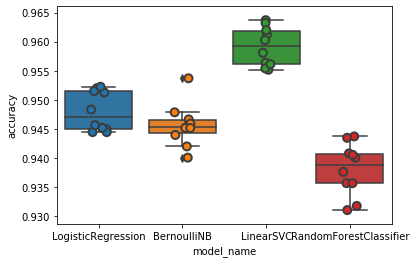

In [68]:
# Training: We use 4 different models and 10 fold cross validation to see which one is better
models = [
    LogisticRegression(),
    BernoulliNB(),
    LinearSVC(),
    RandomForestClassifier()
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in tqdm(models):
     model_name = model.__class__.__name__
     accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
     for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
#cv_df
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [69]:
testDocs = df_test.Abstract.tolist() 
testLabels = df_test.InfoTheory.tolist()

# Use the same vectorizer to transform the test set
x_test=vectorizer.transform(testDocs)
y_test=np.asarray(testLabels)

In [70]:
models = [
    LogisticRegression(),
    BernoulliNB(),
    LinearSVC(),
    RandomForestClassifier()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    
    # print confusion matrix using confusion_matrix
    print(pd.DataFrame(confusion_matrix(y_test,y_predict),columns=['Pred=True','Pred=False'],index=['Actual=True','Actual=False']))
    
    # calculate recall, precision, f1 score, accuracy, mcc
    recall = recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))


LogisticRegression
              Pred=True  Pred=False
Actual=True       15915         147
Actual=False        931        2685
Accuracy: 0.9452180099603619
Macro Precision: 0.9464139377249943
Macro Recall: 0.8666905749898347
Macro F1 score:0.9000291925967907
MCC:0.8091867114772818
BernoulliNB
              Pred=True  Pred=False
Actual=True       15546         516
Actual=False        545        3071
Accuracy: 0.9460819188941966
Macro Precision: 0.9111386665368872
Macro Recall: 0.9085777299083309
Macro F1 score:0.909850893871265
MCC:0.8197123960296797
LinearSVC
              Pred=True  Pred=False
Actual=True       15828         234
Actual=False        639        2977
Accuracy: 0.9556357353389572
Macro Precision: 0.9441603117903086
Macro Recall: 0.9043584256746259
Macro F1 score:0.9226438967150643
MCC:0.847584720066803
RandomForestClassifier
              Pred=True  Pred=False
Actual=True       15937         125
Actual=False       1170        2446
Accuracy: 0.9341904665108243
Macro Precis

### For Machine Learning methods, all four methods have very high accuracy, but <font color='blue'>LinearSVC</font> has the highest F1 score and MCC. So LinearSVC fits this dataset better and out performs other methods.

### Machine Learning For CompVis

In [71]:

trainCompVis = train_df.CompVis.tolist()
y_train=np.asarray(trainCompVis)

In [72]:

testCompVis = df_test.CompVis.tolist()

# Use the same vectorizer to transform the test set
x_test=vectorizer.transform(testDocs)
y_test=np.asarray(testCompVis)

In [73]:
models = [
    LogisticRegression(),
    BernoulliNB(),
    LinearSVC(),
    RandomForestClassifier()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    
    # print confusion matrix using confusion_matrix
    print(pd.DataFrame(confusion_matrix(y_test,y_predict),columns=['Pred=True','Pred=False'],index=['Actual=True','Actual=False']))
    
    # calculate recall, precision, f1 score, accuracy, mcc
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))


LogisticRegression
              Pred=True  Pred=False
Actual=True       17472          54
Actual=False        994        1158
Accuracy: 0.9467425551377172
Macro Precision: 0.9508084432400783
Macro Recall: 0.7675114763111375
Macro F1 score:0.8296742650434408
MCC:0.6945399403480811
BernoulliNB
              Pred=True  Pred=False
Actual=True       17439          87
Actual=False       1076        1076
Accuracy: 0.9408984652911881
Macro Precision: 0.9335392116591577
Macro Recall: 0.7475179732968162
Macro F1 score:0.8084508162168083
MCC:0.6551602766180932
LinearSVC
              Pred=True  Pred=False
Actual=True       17446          80
Actual=False        527        1625
Accuracy: 0.969153369244842
Macro Precision: 0.9618787092336125
Macro Recall: 0.8752734386765579
Macro F1 score:0.9127623638340921
MCC:0.8326603424340272
RandomForestClassifier
              Pred=True  Pred=False
Actual=True       17501          25
Actual=False       1345         807
Accuracy: 0.9303791035674357
Macro Preci

### Again, <font color='blue'> LinearSVC</font> has the highest F1 score and MCC, thus, it fits this dataset better and outperforms other methods

### Machine Learning For Math

In [74]:
trainMath = train_df.Math.tolist()
y_train=np.asarray(trainMath)

In [75]:
testMath = df_test.Math.tolist()

# Use the same vectorizer to transform the test set
x_test=vectorizer.transform(testDocs)
y_test=np.asarray(testMath)

In [76]:
models = [
    LogisticRegression(),
    BernoulliNB(),
    LinearSVC(),
    RandomForestClassifier()
]

for clf in models:
    model_name = clf.__class__.__name__
    clf.fit(x_train, y_train)
    print(model_name)
    # Do the prediction
    y_predict=clf.predict(x_test)
    
    # print confusion matrix using confusion_matrix
    print(pd.DataFrame(confusion_matrix(y_test,y_predict),columns=['Pred=True','Pred=False'],index=['Actual=True','Actual=False']))
    
    # calculate recall, precision, f1 score, accuracy, mcc
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression
              Pred=True  Pred=False
Actual=True       13046         702
Actual=False       1828        4102
Accuracy: 0.8714300233763593
Macro Precision: 0.8654863775503292
Macro Recall: 0.8203374791047332
Macro F1 score:0.8379534052935732
MCC:0.6843361303675065
BernoulliNB
              Pred=True  Pred=False
Actual=True       12126        1622
Actual=False       1129        4801
Accuracy: 0.8601992072365078
Macro Precision: 0.8311473120369184
Macro Recall: 0.8458156722228737
Macro F1 score:0.8377117456560791
MCC:0.6768040493875451
LinearSVC
              Pred=True  Pred=False
Actual=True       12820         928
Actual=False       1476        4454
Accuracy: 0.8778331131212521
Macro Precision: 0.8621638648341161
Macro Recall: 0.8417976970189992
Macro F1 score:0.8508799417444037
MCC:0.7036668954663166
RandomForestClassifier
              Pred=True  Pred=False
Actual=True       13565         183
Actual=False       3051        2879
Accuracy: 0.8356540298810855
Macro Prec

### Andn again, <font color='blue'> LinearSVC</font> has the highest F1 score and MCC, thus, it fits this dataset better and outperforms other methods.

### The confusion matrix is printed above for each methods

# Part 2: Topic Modelling

General comments and any shared processing here.


In [77]:
%matplotlib inline

In [78]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [79]:

import pandas as pd
text_data = []
df = pd.read_csv('Monash_crawled.csv')
docs = df['body'].tolist()
print(len(docs))
print(docs[0][0:500])

366
 Canberra
 has experienced its worst air quality on record, as bushfire smoke 
became trapped by atmospheric conditions and residents were told to stay
 indoors and brace for more smog in the coming days.   The ACTas 
acting chief health officer, Dr Paul Dugdale, said the smoke was the 
worst since the 2003 bushfires and was acertainly the worsta since air 
quality monitoring started in the city 15 years ago.   Air quality 
index readings in Canberra city were at 3,463 on Wednesday afternoon, 
a


## LDA Run 1

Pre-process and vectorize the documents
---------------------------------------

As part of preprocessing, we will:

* Tokenize (split the documents into tokens).
* Lemmatize the tokens.
* Compute bigrams.
* Compute a bag-of-words representation of the data.



In [80]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [81]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [82]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2020-05-09 10:11:57,721 : WARNING : unable to import 'smart_open.gcs', disabling that module
2020-05-09 10:11:58,251 : INFO : collecting all words and their counts
2020-05-09 10:11:58,251 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-09 10:11:58,586 : INFO : collected 134249 word types from a corpus of 318836 words (unigram + bigrams) and 366 sentences
2020-05-09 10:11:58,587 : INFO : using 134249 counts as vocab in Phrases<0 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>


In [83]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

2020-05-09 10:11:59,356 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-09 10:11:59,563 : INFO : built Dictionary(15592 unique tokens: ['1am', '42c', 'a', 'a_well', 'aavoid']...) from 366 documents (total 338108 corpus positions)
2020-05-09 10:11:59,583 : INFO : discarding 14180 tokens: [('1am', 4), ('42c', 1), ('a', 340), ('aavoid', 1), ('acertainly', 1), ('actas', 1), ('acting', 16), ('advise', 7), ('aextremely', 1), ('air_pollution', 8)]...
2020-05-09 10:11:59,584 : INFO : keeping 1412 tokens which were in no less than 20 and no more than 183 (=50.0%) documents
2020-05-09 10:11:59,588 : INFO : resulting dictionary: Dictionary(1412 unique tokens: ['a_well', 'able', 'able_to', 'above', 'according']...)


In [84]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [85]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1412
Number of documents: 366


#### Train LDA model

In [86]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
NUM_TOPICS = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

2020-05-09 10:11:59,690 : INFO : using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
2020-05-09 10:11:59,691 : INFO : using serial LDA version on this node
2020-05-09 10:11:59,695 : INFO : running online (multi-pass) LDA training, 20 topics, 20 passes over the supplied corpus of 366 documents, updating model once every 366 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2020-05-09 10:11:59,695 : INFO : PROGRESS: pass 0, at document #366/366
2020-05-09 10:12:01,295 : INFO : optimized alpha [0.037417836, 0.04356393, 0.04052582, 0.04053188, 0.039094128, 0.043480776, 0.03883386, 0.038740702, 0.036394533, 0.04794497, 0.04239233, 0.040887218, 0.038326755, 0.036614038, 0.03609738, 0.049644504, 0.041986212, 0.04447888, 0.038159344, 0.038300335]
2020-05-09 10:12:01,322 : INFO : topic #14 (0.036): 0.010*"you" + 0.009*"wuhan" + 0.009

2020-05-09 10:12:03,358 : INFO : optimized alpha [0.031315926, 0.032039892, 0.028517237, 0.0328893, 0.032398432, 0.040474597, 0.02700495, 0.031778872, 0.024003137, 0.045790765, 0.03790306, 0.035261422, 0.031416308, 0.024055002, 0.023127692, 0.042800326, 0.028289186, 0.040607017, 0.026562788, 0.029542824]
2020-05-09 10:12:03,362 : INFO : topic #14 (0.023): 0.017*"you" + 0.014*"them" + 0.013*"men" + 0.013*"child" + 0.012*"woman" + 0.012*"control" + 0.009*"what" + 0.009*"system" + 0.008*"do" + 0.007*"call"
2020-05-09 10:12:03,362 : INFO : topic #8 (0.024): 0.017*"woman" + 0.013*"our" + 0.012*"per" + 0.012*"professor" + 0.011*"research" + 0.010*"through" + 0.010*"cent" + 0.010*"body" + 0.010*"researcher" + 0.010*"team"
2020-05-09 10:12:03,363 : INFO : topic #17 (0.041): 0.012*"wuhan" + 0.009*"flight" + 0.008*"confirmed" + 0.008*"symptom" + 0.008*"melbourne" + 0.007*"chinese" + 0.007*"patient" + 0.007*"outbreak" + 0.006*"sydney" + 0.006*"infected"
2020-05-09 10:12:03,363 : INFO : topic #15 

2020-05-09 10:12:04,870 : INFO : topic #13 (0.020): 0.029*"indonesia" + 0.025*"school" + 0.016*"trade" + 0.011*"child" + 0.010*"aedt" + 0.010*"education" + 0.010*"morrison" + 0.009*"billion" + 0.009*"between" + 0.009*"deal"
2020-05-09 10:12:04,871 : INFO : topic #17 (0.041): 0.012*"wuhan" + 0.009*"flight" + 0.008*"symptom" + 0.008*"confirmed" + 0.008*"melbourne" + 0.007*"patient" + 0.007*"chinese" + 0.007*"hospital" + 0.007*"sydney" + 0.007*"outbreak"
2020-05-09 10:12:04,871 : INFO : topic #5 (0.043): 0.021*"ship" + 0.019*"passenger" + 0.016*"cruise" + 0.013*"japan" + 0.012*"princess" + 0.011*"flight" + 0.011*"diamond" + 0.011*"diamond_princess" + 0.011*"cruise_ship" + 0.010*"quarantine"
2020-05-09 10:12:04,871 : INFO : topic #9 (0.045): 0.020*"wuhan" + 0.013*"chinese" + 0.010*"outbreak" + 0.009*"confirmed" + 0.009*"saturday" + 0.008*"death" + 0.008*"kong" + 0.008*"hong" + 0.007*"hong_kong" + 0.007*"on_saturday"
2020-05-09 10:12:04,872 : INFO : topic diff=0.405456, rho=0.288675
2020-05

2020-05-09 10:12:06,634 : INFO : topic #9 (0.045): 0.021*"wuhan" + 0.013*"chinese" + 0.011*"outbreak" + 0.010*"saturday" + 0.009*"confirmed" + 0.009*"death" + 0.009*"kong" + 0.009*"hong" + 0.008*"hong_kong" + 0.008*"on_saturday"
2020-05-09 10:12:06,635 : INFO : topic #5 (0.046): 0.021*"ship" + 0.019*"passenger" + 0.015*"cruise" + 0.012*"japan" + 0.012*"flight" + 0.012*"princess" + 0.011*"island" + 0.011*"quarantine" + 0.010*"board" + 0.010*"diamond"
2020-05-09 10:12:06,635 : INFO : topic diff=0.244474, rho=0.242536
2020-05-09 10:12:06,637 : INFO : PROGRESS: pass 16, at document #366/366
2020-05-09 10:12:07,065 : INFO : optimized alpha [0.03207095, 0.027650593, 0.02187884, 0.032793555, 0.032385465, 0.046283487, 0.020653129, 0.032417644, 0.020296983, 0.04523897, 0.041592553, 0.033361237, 0.027985148, 0.018225985, 0.017077792, 0.039194662, 0.021594051, 0.0428293, 0.022059517, 0.02642299]
2020-05-09 10:12:07,068 : INFO : topic #14 (0.017): 0.023*"men" + 0.022*"child" + 0.019*"you" + 0.017*

Saving model in model20.gensim



In [87]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -1.1205.
[([(0.02092598, 'ship'),
   (0.019536879, 'passenger'),
   (0.015125455, 'cruise'),
   (0.012499751, 'flight'),
   (0.012388948, 'japan'),
   (0.011397397, 'princess'),
   (0.011332206, 'island'),
   (0.010821334, 'quarantine'),
   (0.010522381, 'board'),
   (0.010412159, 'cruise_ship'),
   (0.010335109, 'diamond'),
   (0.010275439, 'diamond_princess'),
   (0.009610976, 'on_board'),
   (0.009081654, 'wuhan'),
   (0.009053124, 'christmas_island'),
   (0.00903742, 'christmas'),
   (0.007936855, 'february_february'),
   (0.0076975175, 'january_january'),
   (0.0073500113, 'evacuee'),
   (0.0070899557, 'confirmed')],
  -0.6876092914125729),
 ([(0.021430451, 'wuhan'),
   (0.013659175, 'chinese'),
   (0.011770166, 'outbreak'),
   (0.010733775, 'saturday'),
   (0.009901553, 'death'),
   (0.009593752, 'confirmed'),
   (0.009348426, 'kong'),
   (0.009341995, 'hong'),
   (0.009225992, 'hong_kong'),
   (0.009001574, 'on_saturday'),
   (0.007976654, 'disease'),
  

In [88]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

2020-05-09 10:12:09,343 : INFO : NumExpr defaulting to 8 threads.


## LDA Run 2

In [104]:

import pandas as pd
text_data = []
df = pd.read_csv('Monash_crawled.csv')
docs = df['body'].tolist()

In [105]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [106]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [107]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phrases(docs, min_count=10)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

2020-05-09 11:14:40,940 : INFO : collecting all words and their counts
2020-05-09 11:14:40,941 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-09 11:14:41,305 : INFO : collected 134249 word types from a corpus of 318836 words (unigram + bigrams) and 366 sentences
2020-05-09 11:14:41,306 : INFO : using 134249 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>


In [108]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 10 documents, or more than 70% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.7)

2020-05-09 11:14:42,118 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-09 11:14:42,345 : INFO : built Dictionary(15988 unique tokens: ['1am', '42c', 'a', 'a_well', 'aavoid']...) from 366 documents (total 344146 corpus positions)
2020-05-09 11:14:42,369 : INFO : discarding 13260 tokens: [('1am', 4), ('42c', 1), ('a', 340), ('aavoid', 1), ('acertainly', 1), ('actas', 1), ('advise', 7), ('aextremely', 1), ('air_pollution', 8), ('alast', 1)]...
2020-05-09 11:14:42,369 : INFO : keeping 2728 tokens which were in no less than 10 and no more than 256 (=70.0%) documents
2020-05-09 11:14:42,376 : INFO : resulting dictionary: Dictionary(2728 unique tokens: ['a_well', 'able', 'able_to', 'above', 'according']...)


In [109]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [110]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2728
Number of documents: 366


In [111]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
NUM_TOPICS = 40
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model.save(outputfile)

2020-05-09 11:14:42,500 : INFO : using autotuned alpha, starting with [0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
2020-05-09 11:14:42,501 : INFO : using serial LDA version on this node
2020-05-09 11:14:42,510 : INFO : running online (multi-pass) LDA training, 40 topics, 20 passes over the supplied corpus of 366 documents, updating model once every 366 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2020-05-09 11:14:42,511 : INFO : PROGRESS: pass 0, at document #366/366
2020-05-09 11:14:44,576 : INFO : optimized alpha [0.022994602, 0.021010522, 0.024025217, 0.021166116, 0.021162346, 0.022097891, 0.021699943, 0.02116357, 0.029339004, 0.023702847, 0.021314725, 0.022545047, 0.021324351, 0.021628797

2020-05-09 11:14:49,787 : INFO : topic #24 (0.016): 0.000*"alarm" + 0.000*"becomes" + 0.000*"context" + 0.000*"empty" + 0.000*"imperial" + 0.000*"language" + 0.000*"positive" + 0.000*"sometimes" + 0.000*"spoke" + 0.000*"camp"
2020-05-09 11:14:49,788 : INFO : topic #16 (0.016): 0.004*"patient" + 0.004*"car" + 0.002*"discharged" + 0.002*"vehicle" + 0.002*"virus" + 0.001*"china" + 0.001*"if" + 0.001*"some" + 0.001*"positive" + 0.001*"you"
2020-05-09 11:14:49,789 : INFO : topic #39 (0.028): 0.018*"china" + 0.017*"february" + 0.012*"student" + 0.012*"coronavirus" + 0.012*"january" + 0.012*"chinese" + 0.008*"ban" + 0.008*"case" + 0.008*"australian" + 0.007*"travel"
2020-05-09 11:14:49,789 : INFO : topic #8 (0.032): 0.012*"we" + 0.008*"he" + 0.008*"could" + 0.008*"can" + 0.007*"say" + 0.006*"australian" + 0.005*"one" + 0.005*"up" + 0.004*"government" + 0.004*"would"
2020-05-09 11:14:49,790 : INFO : topic #27 (0.037): 0.015*"virus" + 0.012*"coronavirus" + 0.009*"china" + 0.009*"january" + 0.00

2020-05-09 11:14:53,437 : INFO : topic diff=0.714385, rho=0.316228
2020-05-09 11:14:53,444 : INFO : PROGRESS: pass 9, at document #366/366
2020-05-09 11:14:54,248 : INFO : optimized alpha [0.021089554, 0.0139088705, 0.022444585, 0.014934008, 0.013885864, 0.015720597, 0.018726014, 0.0153521765, 0.033907637, 0.019289749, 0.015161911, 0.016279489, 0.015865762, 0.0155593855, 0.016696556, 0.019017756, 0.013450473, 0.0237156, 0.014671148, 0.015215328, 0.014471498, 0.0183296, 0.018088358, 0.014899811, 0.013330355, 0.021605346, 0.015048555, 0.0423386, 0.014108508, 0.015551108, 0.016722387, 0.017437503, 0.01772116, 0.014949653, 0.017739441, 0.015661195, 0.028956413, 0.031737287, 0.015926618, 0.029335696]
2020-05-09 11:14:54,259 : INFO : topic #24 (0.013): 0.000*"alarm" + 0.000*"becomes" + 0.000*"context" + 0.000*"empty" + 0.000*"imperial" + 0.000*"language" + 0.000*"positive" + 0.000*"sometimes" + 0.000*"spoke" + 0.000*"camp"
2020-05-09 11:14:54,260 : INFO : topic #16 (0.013): 0.001*"patient" +

2020-05-09 11:14:57,565 : INFO : topic #37 (0.035): 0.037*"february" + 0.026*"january" + 0.020*"coronavirus" + 0.018*"australian" + 0.009*"south" + 0.009*"virus" + 0.008*"china" + 0.008*"we" + 0.008*"february_february" + 0.008*"january_january"
2020-05-09 11:14:57,566 : INFO : topic #8 (0.036): 0.015*"we" + 0.010*"could" + 0.010*"can" + 0.010*"he" + 0.010*"say" + 0.006*"one" + 0.005*"up" + 0.005*"just" + 0.005*"into" + 0.005*"such"
2020-05-09 11:14:57,567 : INFO : topic #27 (0.045): 0.017*"virus" + 0.012*"coronavirus" + 0.011*"china" + 0.009*"wuhan" + 0.009*"case" + 0.008*"january" + 0.008*"health" + 0.006*"confirmed" + 0.006*"he" + 0.006*"two"
2020-05-09 11:14:57,567 : INFO : topic diff=0.353785, rho=0.258199
2020-05-09 11:14:57,574 : INFO : PROGRESS: pass 14, at document #366/366
2020-05-09 11:14:58,428 : INFO : optimized alpha [0.02211755, 0.012447373, 0.023426099, 0.013668728, 0.01232779, 0.014626446, 0.019199518, 0.014682581, 0.03596342, 0.019443056, 0.014159773, 0.0150826685, 0.0

2020-05-09 11:15:02,005 : INFO : topic #24 (0.011): 0.000*"alarm" + 0.000*"becomes" + 0.000*"context" + 0.000*"empty" + 0.000*"imperial" + 0.000*"language" + 0.000*"positive" + 0.000*"sometimes" + 0.000*"spoke" + 0.000*"camp"
2020-05-09 11:15:02,006 : INFO : topic #16 (0.011): 0.000*"patient" + 0.000*"car" + 0.000*"discharged" + 0.000*"vehicle" + 0.000*"virus" + 0.000*"china" + 0.000*"if" + 0.000*"some" + 0.000*"positive" + 0.000*"you"
2020-05-09 11:15:02,006 : INFO : topic #8 (0.038): 0.015*"we" + 0.011*"could" + 0.011*"can" + 0.010*"say" + 0.010*"he" + 0.006*"one" + 0.006*"up" + 0.005*"just" + 0.005*"such" + 0.005*"into"
2020-05-09 11:15:02,007 : INFO : topic #37 (0.039): 0.038*"february" + 0.027*"january" + 0.020*"coronavirus" + 0.018*"australian" + 0.010*"south" + 0.009*"virus" + 0.009*"we" + 0.008*"china" + 0.008*"health" + 0.008*"february_february"
2020-05-09 11:15:02,008 : INFO : topic #27 (0.048): 0.018*"virus" + 0.012*"coronavirus" + 0.011*"china" + 0.009*"wuhan" + 0.009*"case

Saving model in model40.gensim



In [112]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -1.2933.
[([(0.017618403, 'virus'),
   (0.012175736, 'coronavirus'),
   (0.011167812, 'china'),
   (0.009419285, 'wuhan'),
   (0.009399285, 'case'),
   (0.008480543, 'health'),
   (0.00785501, 'january'),
   (0.006451968, 'confirmed'),
   (0.005986652, 'two'),
   (0.0057216133, 'patient'),
   (0.0055410764, 'he'),
   (0.0055033667, 'symptom'),
   (0.00495014, 'infected'),
   (0.0048024585, 'outbreak'),
   (0.0047745914, 'spread'),
   (0.0046101282, 'chinese'),
   (0.0045623668, 'have_been'),
   (0.0045546712, 'we'),
   (0.0044569722, 'one'),
   (0.004412526, 'can')],
  -0.44051052015075537),
 ([(0.037732337, 'february'),
   (0.027010117, 'january'),
   (0.01994897, 'coronavirus'),
   (0.018431839, 'australian'),
   (0.009592876, 'south'),
   (0.009264605, 'virus'),
   (0.008870651, 'we'),
   (0.008082786, 'health'),
   (0.008023146, 'china'),
   (0.007992274, 'february_february'),
   (0.007820161, 'january_january'),
   (0.007596614, 'queensland'),
   (0.007300

In [113]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)